Time series, tomato price predicted with random forest:


Random Forests don’t fit very well for increasing or decreasing trends which are usually encountered when dealing with time-series analysis, such as seasonality! 

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve




In [2]:
# Load data
data = pd.read_csv("data/all_data.csv")
del data['day']
data_copy = data.copy()
data.head(3)


,temperature_max,temperature_min,humidity,precip_intensity,precip_intensity_max,pressure,visibility,wind_speed,oil_price,lettuce_price,onion_price,tomato_price
0,0.86,0.22,0.866429,2.21,2.45,101.42,450.37,0.55,31.509143,0.3320,0.3620,0.3900
1,0.80,0.19,0.842143,0.01,0.02,101.66,559.40,0.42,33.266871,0.3325,0.3325,0.3325
2,1.12,0.38,0.791875,0.00,0.02,102.05,487.51,0.49,31.995306,0.3225,0.7225,1.1600


In [3]:
# I check the shape
data.shape

(60, 12)

In [4]:
# round and reemplace missing values for mean
data = data.round(2)
data = data.fillna(value=round(data.mean(), 2))


Text(0.5, 0, 'Tomato price feature')

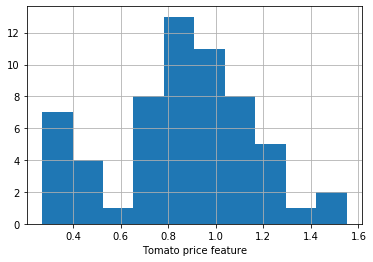

In [5]:
# Display histogram of the price scores
data['tomato_price'].hist()
plt.xlabel('Tomato price feature')

In [6]:
# the histogram seems to be unbalanced


In [7]:
# I build a function to balance the tomato_price column

y = data['tomato_price']
del data['tomato_price']

y_scaled = np.array([1 if x > y.median() else 0 for x in y])

y_multi = np.array([0] * len(y))
for i in range(len(y_multi)):
    if y[i] < np.percentile(y, 33):
        y_multi[i] = 1
    elif y[i] > np.percentile(y, 66):
        y_multi[i] = 2
y_multi 

array([1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 1, 1, 1, 1, 0, 2, 0, 0, 0, 2, 2, 2,
       1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 1, 1, 1, 2, 2, 0, 0, 1,
       2, 2, 1, 0, 0, 1, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1])

Text(0.5, 0, 'Tomato price feature')

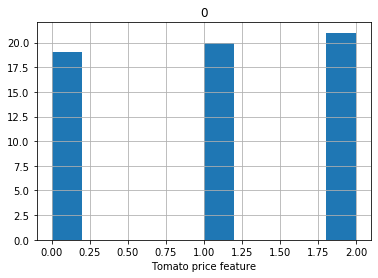

In [8]:
(pd.DataFrame(y_multi)).hist()
plt.xlabel('Tomato price feature')


In [9]:
# the histogram seems balanced

# Baseline model

In [10]:
# Setting up a baseline model with Decision Tree to compare with Random Forest model
num_features = ['temperature_max', 'temperature_min', 'humidity',
       'precip_intensity', 'precip_intensity_max', 'pressure', 'visibility',
       'wind_speed', 'oil_price', 'lettuce_price',
       'onion_price']
df_dt = data[num_features]
X_train, X_test, y_train, y_test = train_test_split(df_dt,
                                                    y_scaled)

Everything_in_one_dt = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA(n_components=3)),
    ("poly", PolynomialFeatures(2)),
    ("model", DecisionTreeClassifier(max_depth=None))])

X = data[num_features]
   
Everything_in_one_dt.fit(X_train, y_train)
Everything_in_one_dt.predict(X_test)

#metrics = (y_test==Everything_in_one_dt.predict(X_test)).mean()
print(classification_report(y_test.astype('int32'),
    Everything_in_one_dt.predict(X_test).astype('int32'),
    target_names=['c1', 'c2']))


              precision    recall  f1-score   support

          c1       0.56      0.83      0.67         6
          c2       0.83      0.56      0.67         9

    accuracy                           0.67        15
   macro avg       0.69      0.69      0.67        15
weighted avg       0.72      0.67      0.67        15



# Random Forest model

In [11]:
# Random Forest model

# I define pipeline for Random Forest

Everything_in_one_RF = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA(n_components=3)),
    ("poly", PolynomialFeatures(2)),
    ("model", RandomForestRegressor())])

X = data[num_features]
   
Everything_in_one_RF.fit(X, np.log(y))
Everything_in_one_RF.predict(X)
print(classification_report(y_scaled.astype('int32'),
    Everything_in_one_RF.predict(X).astype('int32'),
    target_names=['c1', 'c2', 'c3']))
roc_auc_score(y_scaled.astype('int32'), Everything_in_one_RF.predict(X).astype('int32'))

              precision    recall  f1-score   support

          c1       0.00      0.00      0.00         0
          c2       0.50      0.94      0.65        31
          c3       0.00      0.00      0.00        29

    accuracy                           0.48        60
   macro avg       0.17      0.31      0.22        60
weighted avg       0.26      0.48      0.34        60



/Users/pola/miniconda3/envs/ads07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pola/miniconda3/envs/ads07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.532258064516129

In [12]:
# Splitting 
df = data[num_features]
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y_multi)
Everything_in_one_RF.fit(X_train, y_train)
Everything_in_one_RF.predict(X_test)

print(classification_report(y_test.astype('int32'),
    Everything_in_one_RF.predict(X_test).astype('int32'),
    target_names=['c1', 'c2', 'c3']))


/Users/pola/miniconda3/envs/ads07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          c1       0.43      1.00      0.60         3
          c2       0.50      0.67      0.57         6
          c3       0.00      0.00      0.00         6

    accuracy                           0.47        15
   macro avg       0.31      0.56      0.39        15
weighted avg       0.29      0.47      0.35        15



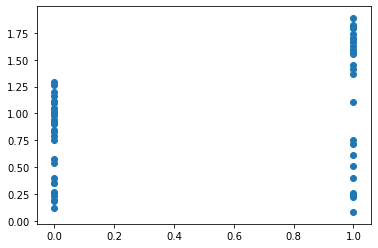

In [13]:
plt.scatter(y_scaled.astype('int32'), Everything_in_one_RF.predict(X))

# Evaluation metrics

In [14]:
# I build confusion_matrix
cm = confusion_matrix(y_scaled.astype('int32'), Everything_in_one_RF.predict(X).astype('int32'))
cm

array([[22,  9],
       [10, 19]])

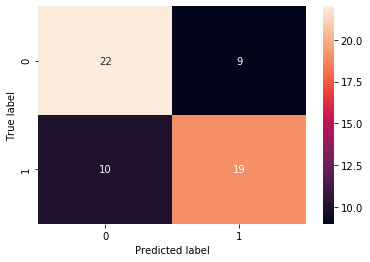

In [15]:

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel(...)
plt.ylabel(...)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



# ROC curves

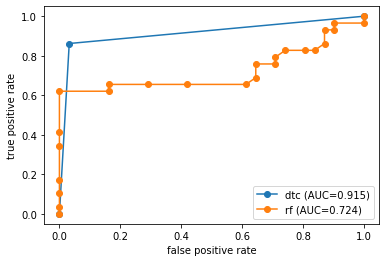

In [16]:
# I build ROC curve to see false positive rate, true positive rate of Decision Tree model and random forest model
classifiers = {
    
    'dtc': Everything_in_one_dt,
    'rf': Everything_in_one_RF

}

for name, clf in classifiers.items():
    y_pred = clf.predict(X)
    fpr, tpr, thresh = roc_curve(y_scaled.astype('int32'), y_pred)
    auc = roc_auc_score(y_scaled.astype('int32'), y_pred)
    plt.plot(fpr, tpr, 'o-', label=f"{name} (AUC={auc:.3f})")

plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()


In [17]:
roc_auc_score(y_scaled.astype('int32'), Everything_in_one_RF.predict(X).astype('int32'))

0.6824249165739711

# Interpretation

In [19]:
# GridSearchCV with  Random Forest Regressor To see the features importance

from sklearn.model_selection import RandomizedSearchCV



rf_model = RandomForestRegressor(random_state = 42)

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {'n_estimators': [20],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [23]:
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [37]:
importances = pd.DataFrame({
    'feature':  X_train.columns,
    'importance': rf_random.best_estimator_.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)
importances

,feature,importance
4,precip_intensity_max,0.183937
5,pressure,0.134350
3,precip_intensity,0.094064
7,wind_speed,0.091951
2,humidity,0.083662
1,temperature_min,0.082597
8,oil_price,0.072724
0,temperature_max,0.070566
6,visibility,0.068504
9,lettuce_price,0.059121


We can see that the maximum precipitation intensity_max, the pressure and precipitation intensity are the features that most affects the variation of price of tomato.

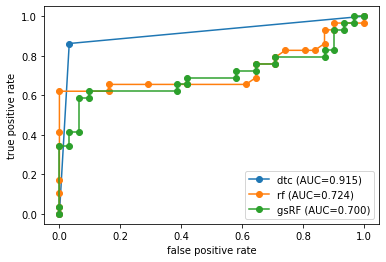

In [30]:
# I build ROC curve to see false positive rate, true positive rate of Decision Tree model and random forest model
classifiers = {
    
    'dtc': Everything_in_one_dt,
    'rf': Everything_in_one_RF,
    'gsRF': rf_random

}

for name, clf in classifiers.items():
    y_pred = clf.predict(X)
    fpr, tpr, thresh = roc_curve(y_scaled.astype('int32'), y_pred)
    auc = roc_auc_score(y_scaled.astype('int32'), y_pred)
    plt.plot(fpr, tpr, 'o-', label=f"{name} (AUC={auc:.3f})")

plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()


Decision Tree is the best result in ROC curves figure